In [227]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
from ipywidgets import widgets
import ConfigReader as cr

In [107]:
reload(cr)

<module 'ConfigReader' from 'ConfigReader.py'>

In [247]:
#Styles
sns.set_style('darkgrid')
sns.set_color_codes()
plt.rcParams['figure.figsize'] = (12.0, 9.0)

plt.rc('text', usetex=False)
plt.rc('font', size=20.0, family='serif')

In [111]:
# Data location and dataset
data_dir = '/mhome/mendozah/constrained_DeepNet_Configs/adam_results/inv'
dataset = '554_bac'

In [112]:
reader = cr.ConfigReader(dataset=dataset)

In [113]:
# Explicitely set the preprocessor to none
tdf, bdf = reader.load_run_configs(data_dir=data_dir, preprocessor=None)

In [195]:
base_data_dir = '/mhome/mendozah/constrained_DeepNet_Configs/'
solvers = ['adam', 'adadelta', 'adagrad', 'nesterov', 'sgd', 'momentum']
policies = ['fixed', 'inv', 'exp', 'step']
interesting_params = [ 'response', 'solver', 'learning_rate', 'beta1', 'beta2',
                      'lambda2', 'lr_policy','gamma', 'power', 'epoch_step']

In [240]:
policy_solver_mean = []
policy_solver_sem = []
params_frame = []
for j in solvers:
    mean_list = []
    sem_list = []
    params_list = []
    for i in policies:
        data_dir = base_data_dir + j + '_results/' + i
        _, bdf = reader.load_run_configs(data_dir=data_dir, preprocessor=None)
        params_list.append(bdf.ix[:, interesting_params])
        mean_list.append(bdf.response.mean())
        sem_list.append(bdf.response.sem())
    solver_mean = np.array(mean_list)
    solver_sem = np.array(sem_list)
    policy_solver_mean.append(solver_mean)
    policy_solver_sem.append(solver_sem)
    params_frame.append(pd.concat(params_list,axis=0))

mean_df = pd.DataFrame(policy_solver_mean, index=solvers, columns=policies)
sem_df = pd.DataFrame(policy_solver_sem, index=solvers, columns=policies)
params_df = pd.concat(params_frame)
params_df.loc[:, 'lr_policy'] = params_df.ix[:,'lr_policy'].fillna('fixed')
params_df = params_df.apply(pd.to_numeric, errors='ignore')

In [241]:
mean_df.applymap(lambda X: "{:.6f}".format(X)) + ' ± ' +sem_df.applymap(lambda x: "{:.6f}".format(x))

,fixed,inv,exp
adam,0.020840 ± 0.001305,0.018825 ± 0.000873,0.025419 ± 0.001084
adadelta,0.034418 ± 0.009656,0.056148 ± 0.013279,0.093845 ± 0.014883
adagrad,0.023592 ± 0.001431,0.025951 ± 0.001655,0.032176 ± 0.002376
nesterov,0.027363 ± 0.001997,0.039485 ± 0.003475,0.057317 ± 0.005833
sgd,0.036222 ± 0.006815,0.040874 ± 0.001807,0.074779 ± 0.013164
momentum,0.028253 ± 0.003903,0.036344 ± 0.002968,0.058095 ± 0.005365


<function __main__.bar_policy>

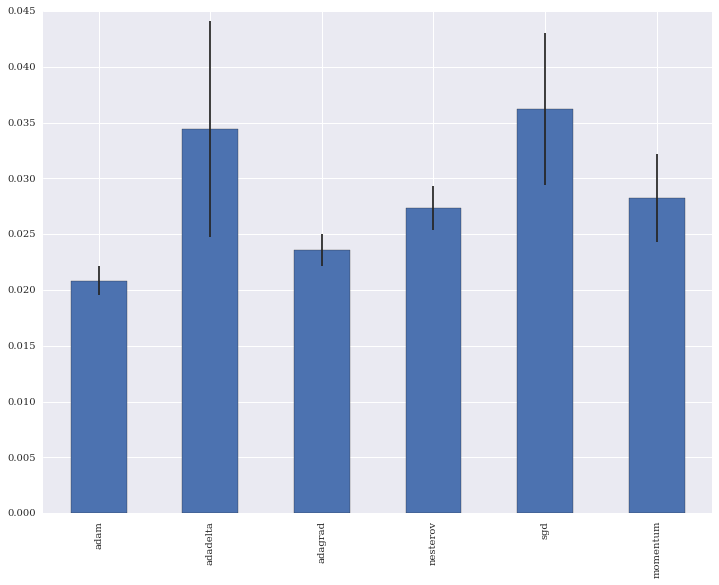

In [208]:
def bar_policy(policies):
    mean_df[policies].plot(kind='bar', yerr=sem_df[policies])

widgets.interact(bar_policy, policies=policies)

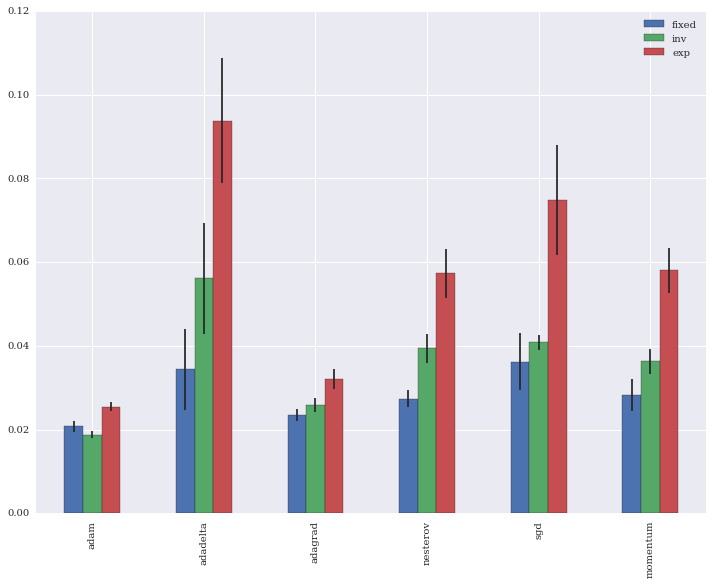

In [209]:
mean_df.plot(kind='bar', yerr=sem_df)

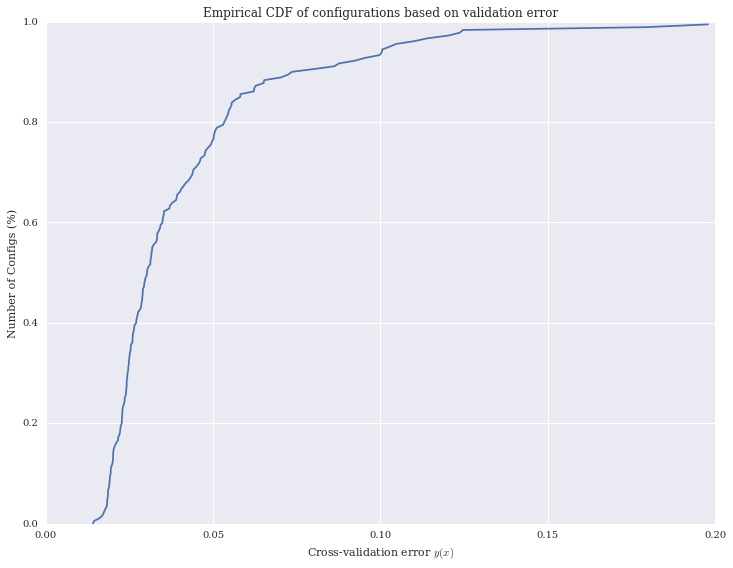

In [219]:
# Plot the empirical CDF
sorted_Y = (params_df.sort_values(by='response', ascending=True)['response'].values)
yvals = np.arange(len(sorted_Y)) / float(len(sorted_Y))

plt.plot( sorted_Y, yvals )
plt.xlabel("Cross-validation error $y(x)$")
plt.ylabel(r"Number of Configs (%)")
plt.xlim(0.0, 0.2)
plt.title("Empirical CDF of configurations based on validation error")
plt.show()

## After Setting the frames. Start with the plotting

In [220]:
## TODO: Review how to make filtered and the figure return
def plotting_threshold(error_threshold, categories):
    #global filtered
    filtered = params_df[params_df.response <= error_threshold]
    fig_f, axs = plt.subplots(ncols=2,nrows=1, figsize=(15.0, 8.5))
    ax0, ax1 = axs.flat
    sns.boxplot(x=categories, y='response', data=filtered, ax=ax0)
    sns.countplot(y=categories, data=filtered, ax=ax1)
    fig_f.tight_layout()

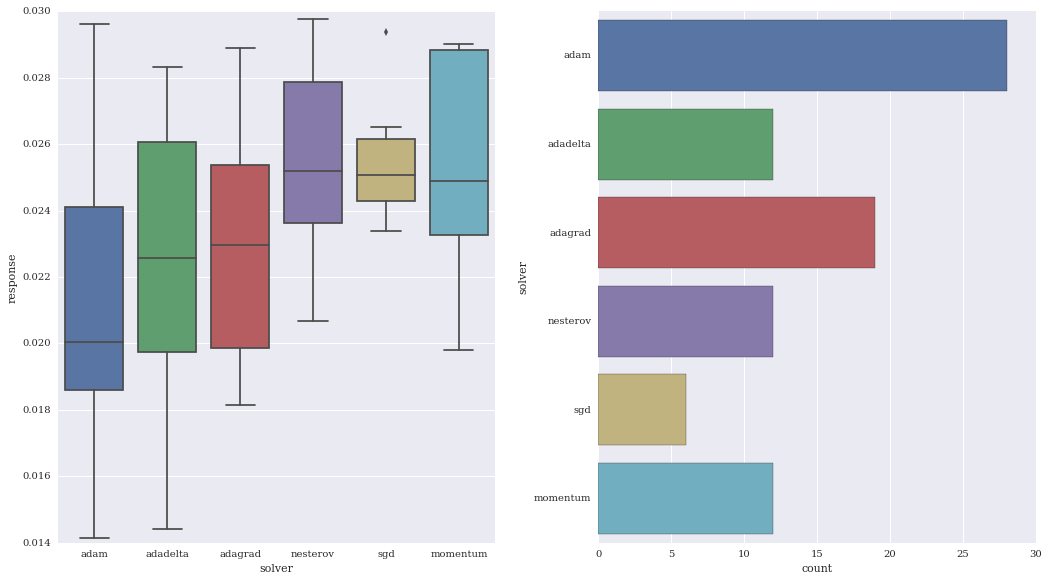

In [221]:
widgets.interact(plotting_threshold, error_threshold=(0.01,0.2,0.01),
                 categories={'Solver':'solver', 'Policy':'lr_policy'})

In [242]:
# Create the grouping of the filtered DF
solver_filt = params_df.groupby('solver')

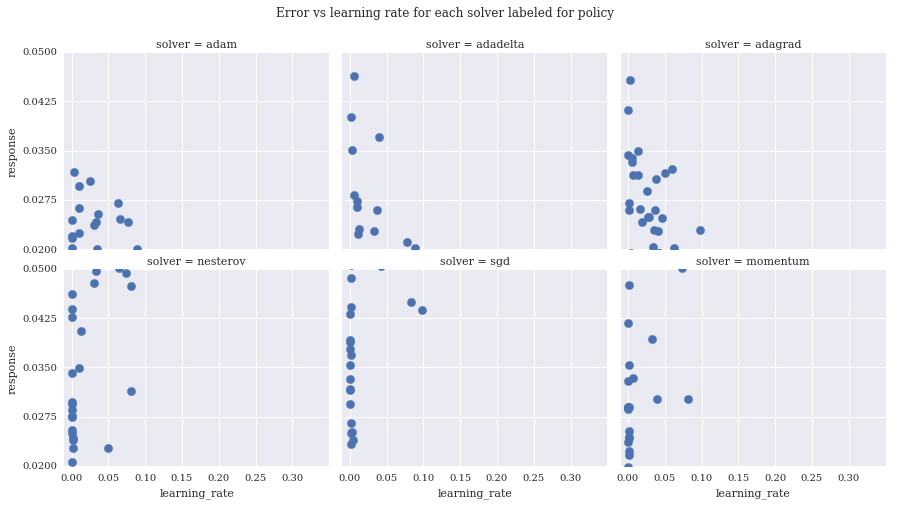

In [250]:
g_scatterGrid = sns.FacetGrid(data=params_df, col='solver',
                              col_wrap=3, size=3.5, aspect=1.2)
g_scatterGrid.map(plt.scatter, 'learning_rate', 'response', s=70)
g_scatterGrid.set(ylim=(0.02,0.05), yticks=np.linspace(0.02,0.05,5),
                  xlim=(-0.01, 0.35), xticks=np.linspace(0.0, 0.30, 7))
g_scatterGrid.add_legend()
g_scatterGrid.fig.suptitle('Error vs learning rate for each solver labeled for policy',
                           fontsize=12, y=1.02)
g_scatterGrid.fig.subplots_adjust(wspace=.05, hspace=.1)

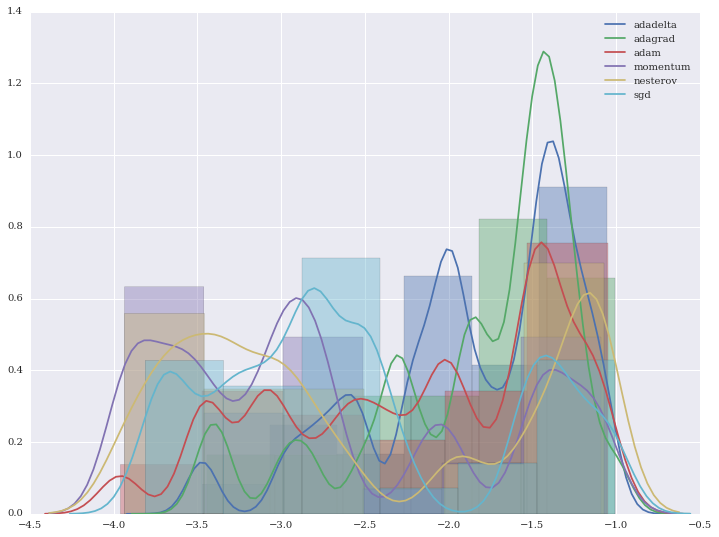

In [251]:
# Seaborns Normed Distribution plots
for name,groups in solver_filt:
    sns.distplot(np.log10(groups.learning_rate.values), bins=6, kde_kws={'label':name, 'bw':0.15})

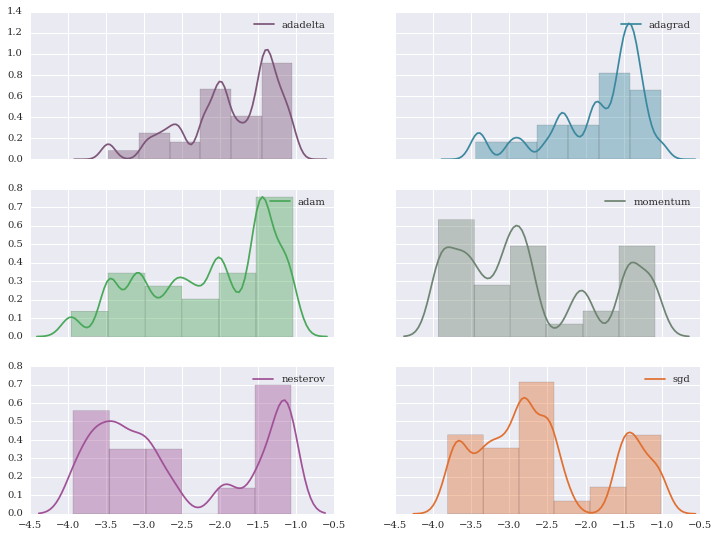

In [270]:
#Subplots of the previous histogram
color_histograms = sns.color_palette('Set1_r',12, desat=1.0)
fig1, axs = plt.subplots(nrows=3, ncols=2, sharey='row', sharex=True)
for iterate_axis, (name, groups) in zip(axs.flat, solver_filt):
    sns.distplot(np.log10(groups.learning_rate.values), bins=6, kde_kws={'label':name, 'bw':0.15},
                 color=color_histograms.pop(), ax=iterate_axis)
    iterate_axis.legend()

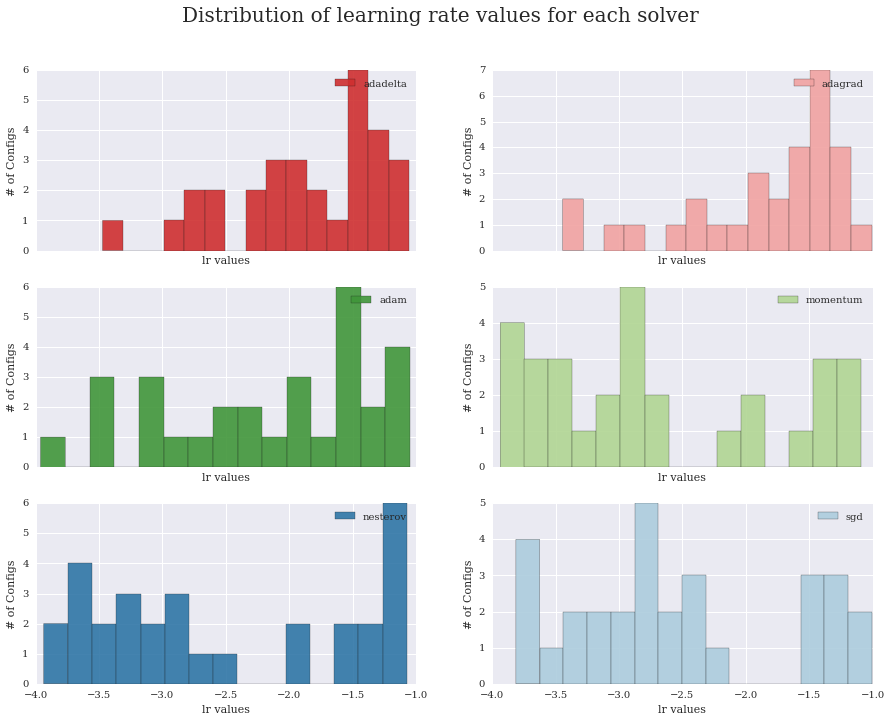

In [256]:
col_hist = sns.color_palette('Paired',6, desat=0.8)

fig2, axs = plt.subplots(nrows=3, ncols=2, sharex=True, figsize=(15.,11.))
fig2.suptitle('Distribution of learning rate values for each solver')
for ax, (name, groups) in zip(axs.flat,solver_filt):
    ax.hist(np.log10(groups.learning_rate.values), bins=15, histtype='bar', fill=True,
            label=name, alpha=0.9, color=col_hist.pop())
    ax.set_xlabel('lr values')
    ax.set_ylabel('# of Configs')
    ax.legend()

In [271]:
# Create the grouping of the filtered DF
prepro_filt = params_df.groupby('lr_policy')

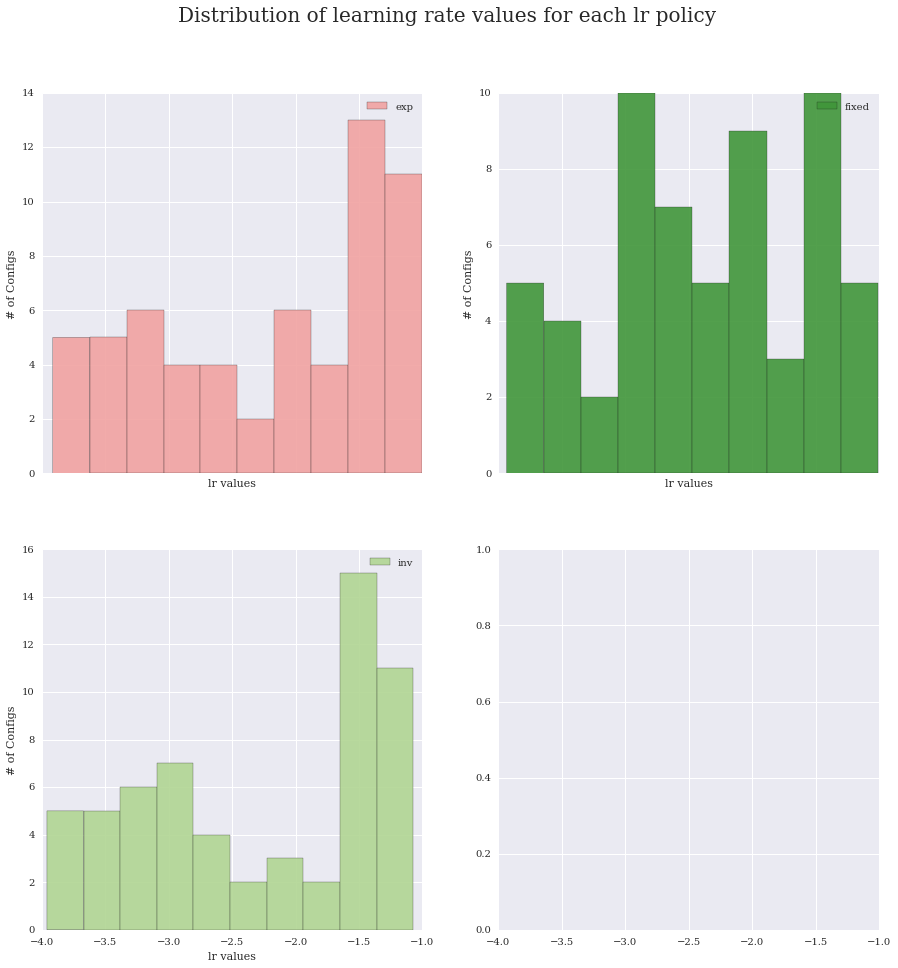

In [272]:
prepro_color = sns.color_palette('Paired',5, desat=0.8)

fig4, axs = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(15.,15.))
fig4.suptitle('Distribution of learning rate values for each lr policy')
for ax, (name, groups) in zip(axs.flat,prepro_filt):
    ax.hist(np.log10(groups.learning_rate.values), bins=10, histtype='bar', fill=True, label=name,
            alpha=0.9, color=prepro_color.pop())
    ax.set_xlabel('lr values')
    ax.set_ylabel('# of Configs')
    ax.legend()

In [134]:
def histogram_group_column_plotting(grouping, column):
    #Have to convert the -1 to NaN
    g = t.groupby(grouping)
    s = len(g)
    col_hist = sns.color_palette('Paired',s, desat=0.8)
    fig_hist, axs = plt.subplots(nrows=s/2, ncols=2, sharex='col', sharey='row', figsize=(15., 11.))
    for ax, (name, groups) in zip(axs.flat,g):
        ax.hist(groups[column].dropna().values, bins=15,
                histtype='bar', fill=True, label=name, alpha=0.9, color=col_hist.pop())
        ax.set_xlabel(column + ' values')
        ax.set_ylabel('# of Configs')
        ax.legend()
    fig_hist.suptitle('Distribution of '+ column +' values for each '+(grouping))

In [137]:
# Create columns dict
Groups = ['solver','preprocessor']
Plott = {'# of Epochs':'epochs', 'batch size':'batch_size','# of Layers':'num_layers',
         'Units of Layer 1':'num_units_layer_1', 'Units of Layer 2':'num_units_layer_2',
         'Units of Layer 3':'num_units_layer_3', 'Units of Layer 4':'num_units_layer_4',
         'Units of Layer 5':'num_units_layer_5', 'Units of Layer 6':'num_units_layer_6',
         'Dropout rate of layer 1':'dropout_layer_1', 'Dropout rate of layer 2':'dropout_layer_2',
         'Dropout rate of layer 3':'dropout_layer_3', 'Dropout rate of layer 4':'dropout_layer_4',
         'Dropout rate of layer 5':'dropout_layer_5', 'Dropout rate at output':'dropout_output',
         'std of layers':'std_layer_1', 'std of layer 2':'std_layer_2', 'std of layer 3':'std_layer_3',
         'std of layer 4':'std_layer_4','std of layer 5':'std_layer_5'}

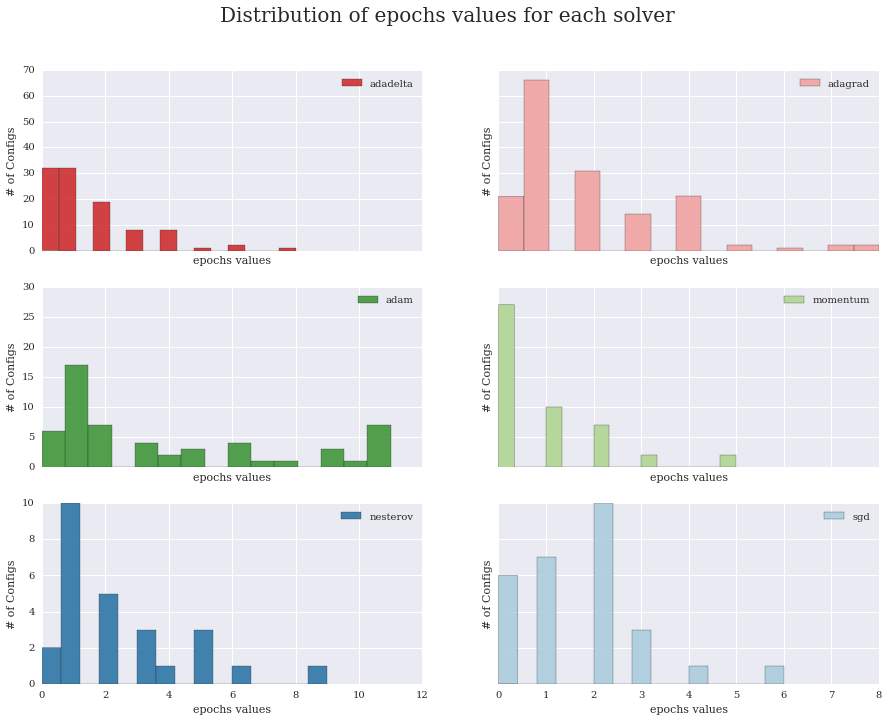

In [138]:
widgets.interact(histogram_group_column_plotting, grouping=Groups, column=Plott)

### Distribution of each parameter over all filtered configurations

In [277]:
def histogram_column_plotting(column):
    #Have to convert the -1 to NaN
    fig_hist = plt.figure(6)
    ax1 = plt.subplot(111)
    ax1.set_title('Histogram of '+column)
    np.log10(params_df[column]).plot(kind='hist', bins=15, ax=ax1)
    ax1.set_xlabel('values')

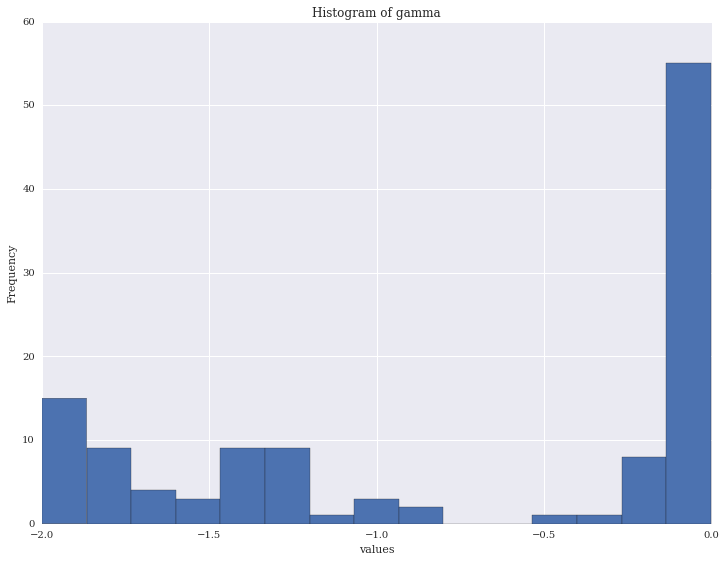

In [278]:
widgets.interact(histogram_column_plotting, column=list(params_df.columns.values[:-1]))